In [714]:
import pandas as pd
import numpy as np
import glob
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from bokeh.plotting import figure
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso

#### Loading the datsets and merging them
- The dates are in different formats before merging the datasets its import to make sure they are in the same format

# EDA

In [715]:
data_sales = pd.concat((pd.read_csv(file,parse_dates=['Date'], date_format='mixed') for file in glob.glob("data/data_sales/*.csv")), ignore_index=True)
data_schedule = pd.concat((pd.read_csv(file,parse_dates=['Date'], date_format='mixed') for file in glob.glob("data/data_schedule/*.csv")), ignore_index=True)
df = data_sales.merge(data_schedule, on="Date", how="left")

#Convert Date to be of type date
df['Date'] = pd.to_datetime(df['Date'])  # Keep full datetime format
df.set_index('Date', inplace=True)  # Set as index so .year works

#Encode Day and Month so that we can use it on mutual regression analysis to check feature importance
df['Day'] = df['Day'].map({'MON': 0,'TUE': 1,'WED': 2,'THU': 3,'FRI': 4,'SAT': 5, 'SUN': 6})
df['Month'] = df['Month'].map({ 'Jan': 0,'Feb': 1,'Mar': 2, 'Apr': 3,'May': 4,'Jun': 5,'Jul': 6, 'Aug': 7,'Sep': 8,'Oct': 9,'Nov': 10,'Dec': 11})


df = df[['event_name', 'Season', 'Game_Number', 'Day',
       'effective_day', 'O_Team', 'Time_Type2', 'Month', 'Weekend', 'School',
       'start_of_homestand', 'end_of_homestand', 'Opening_Day', 'Holiday',
       'Fourth_of_july', 'Final_Game', 'BobbleHead', 'replica',
       'Day_In_Homestand', 'star_wars', 'concert', 'christian_concert',
       'playoff_odds', 'delete', 'afternoon_weekday', 'afternoon_weekend',
       'Week', 'weighted_odds', 'first_homestand', 'Time_Type',
       'Time_of_year','Tier',
         'delete_retail',
         'delete_dnc','Tickets']]

In [716]:
df.shape

(405, 35)

In [717]:
df.describe()

,Season,Game_Number,Day,Time_Type2,Month,Weekend,School,start_of_homestand,end_of_homestand,Opening_Day,...,afternoon_weekday,afternoon_weekend,Week,weighted_odds,first_homestand,Time_Type,Tier,delete_retail,delete_dnc,Tickets
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,...,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,81.000000,81.0,81.0,405.000000
mean,2020.606436,41.089109,3.272277,2.532178,5.490099,0.492574,0.618812,0.170792,0.153465,0.014851,...,0.066832,0.173267,26.680693,2180.960396,0.081683,3.608911,2.777778,0.0,0.0,34235.318519
std,1.854793,23.394597,1.943399,0.822424,1.761851,0.500565,0.486281,0.376794,0.360882,0.121108,...,0.250040,0.378948,7.689026,2145.599608,0.274221,1.452480,1.193734,0.0,0.0,7861.471465
min,2018.000000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,13.000000,3.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000
25%,2019.000000,21.000000,2.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,611.000000,0.000000,3.000000,2.000000,0.0,0.0,28978.000000
50%,2021.000000,41.000000,3.000000,3.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,26.000000,1435.000000,0.000000,4.000000,3.000000,0.0,0.0,36977.000000
75%,2022.000000,61.000000,5.000000,3.000000,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,33.000000,2703.750000,0.000000,5.000000,3.000000,0.0,0.0,40452.000000
max,2023.000000,81.000000,6.000000,3.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,41.000000,8100.000000,1.000000,5.000000,5.000000,0.0,0.0,43619.000000


In [718]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 405 entries, 2018-03-29 to 2023-10-01
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   event_name          405 non-null    object 
 1   Season              404 non-null    float64
 2   Game_Number         404 non-null    float64
 3   Day                 404 non-null    float64
 4   effective_day       404 non-null    object 
 5   O_Team              404 non-null    object 
 6   Time_Type2          404 non-null    float64
 7   Month               404 non-null    float64
 8   Weekend             404 non-null    float64
 9   School              404 non-null    float64
 10  start_of_homestand  404 non-null    float64
 11  end_of_homestand    404 non-null    float64
 12  Opening_Day         404 non-null    float64
 13  Holiday             404 non-null    float64
 14  Fourth_of_july      404 non-null    float64
 15  Final_Game          404 non-null    fl

In [719]:
#Tier, delete_retail and delete_dnc are having a lot of missing values
df.isna().sum().to_frame()

,0
event_name,0
Season,1
Game_Number,1
Day,1
effective_day,1
O_Team,1
Time_Type2,1
Month,1
Weekend,1
School,1


In [720]:
#Drop 1 instance with many null values in numerous features
df = df.dropna(subset=['Game_Number','Day','effective_day','O_Team','Time_Type2'])

#Drop features with many null values and those to be deleted from the instructions given
df = df.drop(columns=['Tier','delete_retail','delete_dnc','delete'])

# Convert all logical columns to integers (1 for True, 0 for False)
convert_cols = [
    "Weekend", "School", "start_of_homestand", "end_of_homestand",
    "Opening_Day", "Holiday", "Fourth_of_july", "Final_Game",
    "BobbleHead", "replica", "star_wars", "concert", "christian_concert", "afternoon_weekday", "afternoon_weekend", "first_homestand",'Day','Month'
]

df[convert_cols] = df[convert_cols].astype(int)

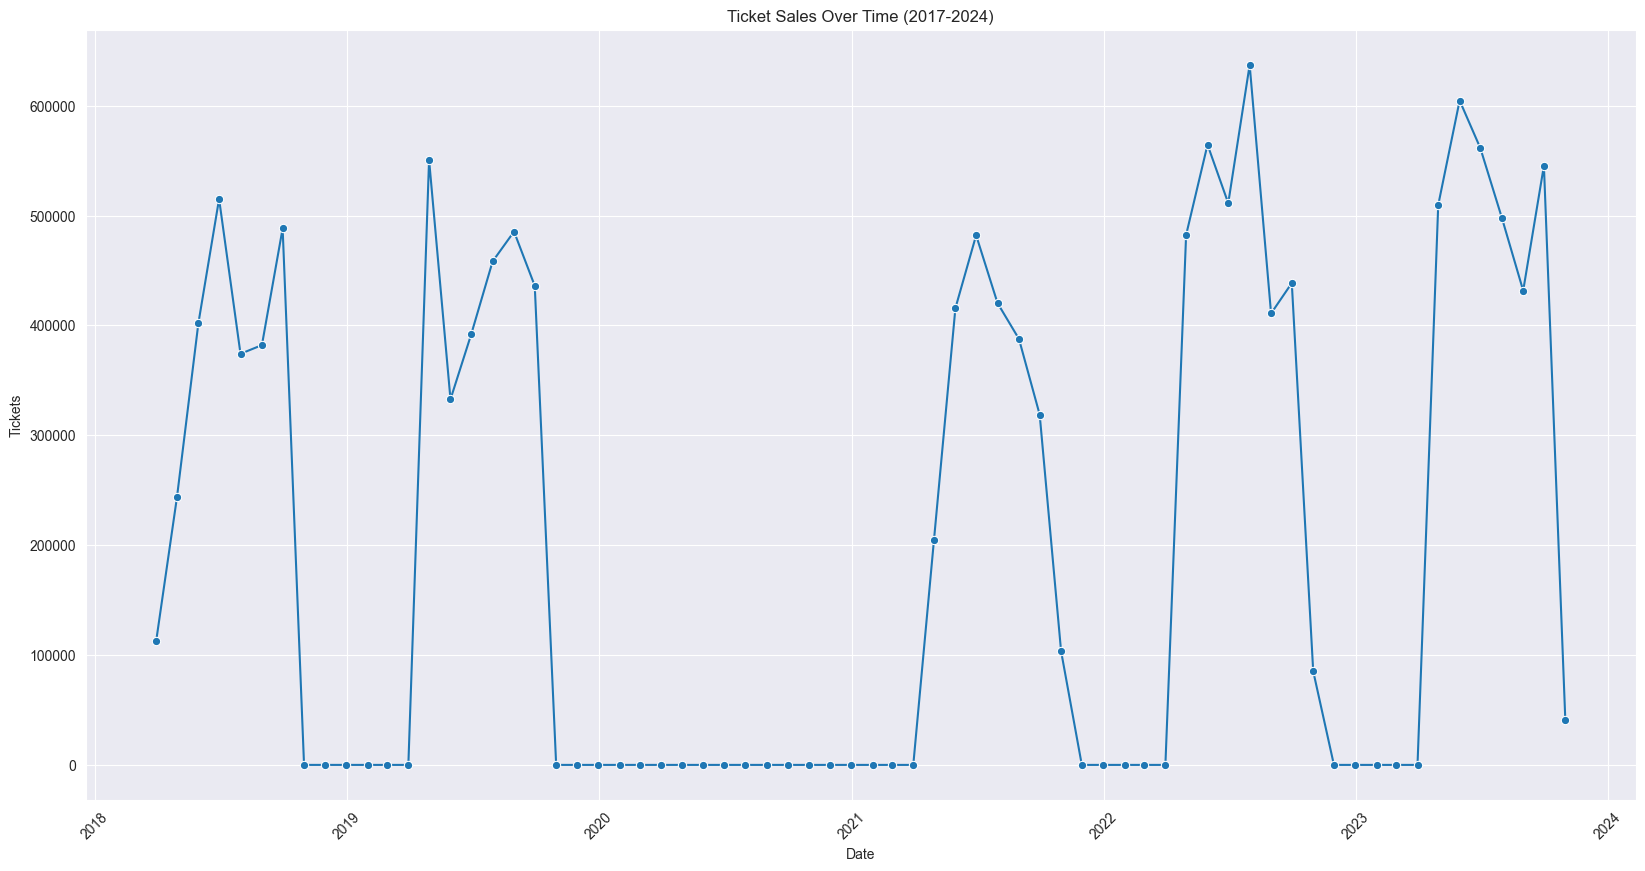

In [721]:
### Ticket Time Series
resampled = df['Tickets'].resample('ME').sum().to_frame()
plt.figure(figsize=(20,10))
sns.lineplot(data=resampled,x=resampled.index,y=resampled['Tickets'],marker='o')
plt.xlabel("Date")
plt.ylabel("Tickets")
plt.title("Ticket Sales Over Time (2017-2024)")
plt.xticks(rotation=45)
plt.show()

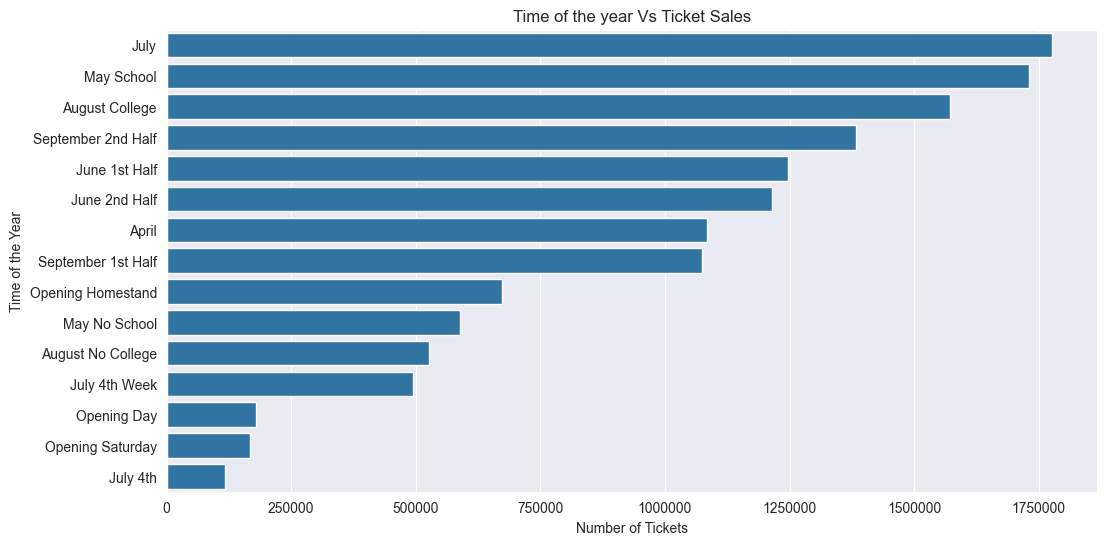

In [722]:
# Time of the year
agg = df.groupby(['Time_of_year'])['Tickets'].sum().reset_index().sort_values(by=['Tickets'],ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(y='Time_of_year', x='Tickets',data=agg,orient='h')
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.title('Time of the year Vs Ticket Sales')
plt.xlabel('Number of Tickets')
plt.ylabel('Time of the Year')
plt.show()

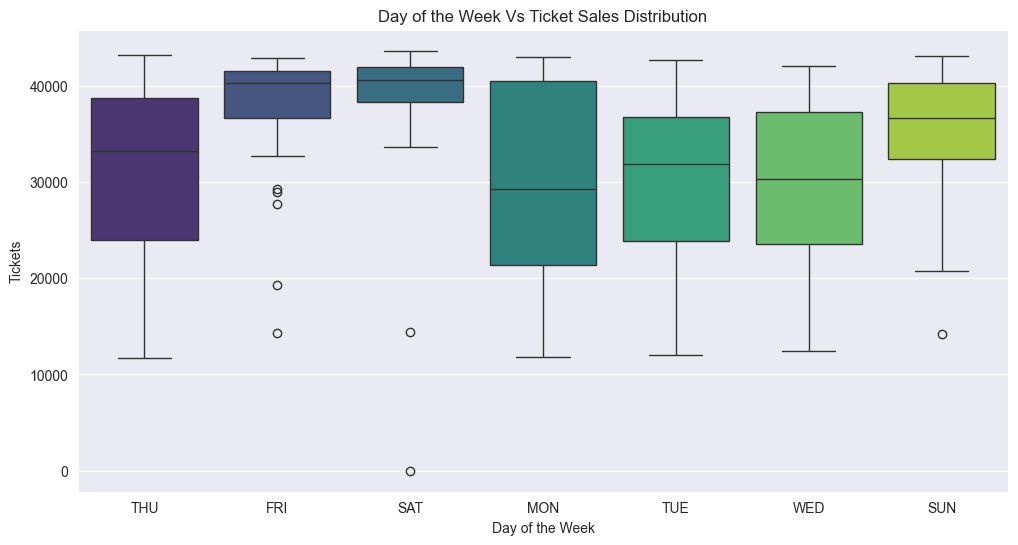

In [723]:
# Day of the Week vs Ticket Sales Distribution
plt.figure(figsize=(12,6))
sns.boxplot(x='effective_day', y='Tickets',hue='effective_day',palette='viridis',data=df)
plt.title('Day of the Week Vs Ticket Sales Distribution')
plt.xlabel('Day of the Week')
plt.ylabel('Tickets')
plt.show()

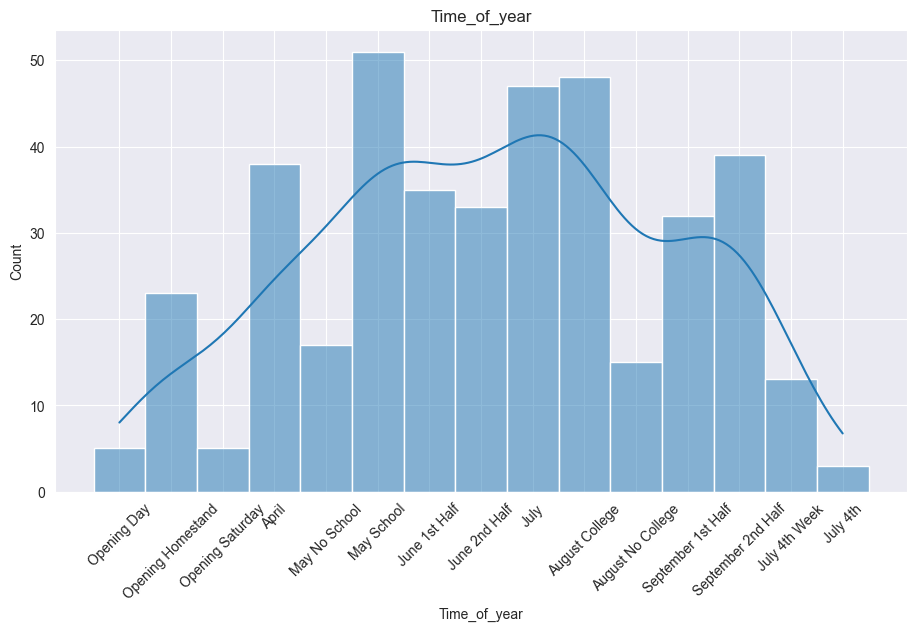

In [724]:
#Time of the Year Distribution
plt.figure(figsize=(11, 6))
sns.histplot(x='Time_of_year', data=df,kde=True)
plt.title('Time_of_year')
plt.xlabel('Time_of_year')
plt.xticks(rotation=45)
plt.show()

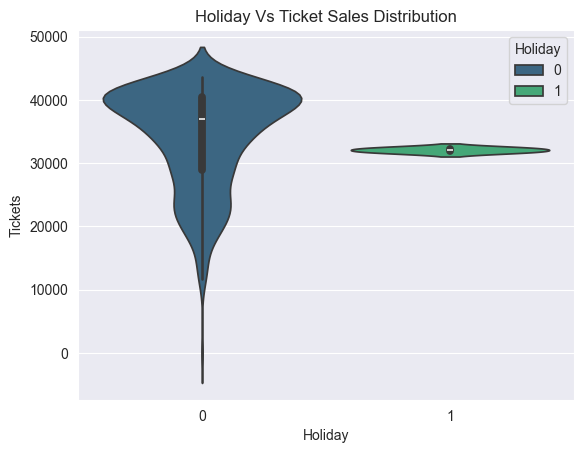

In [725]:
# Holiday vs Ticket Sales Distribution
sns.violinplot(x='Holiday', y='Tickets',hue='Holiday',palette='viridis',data=df)
plt.title('Holiday Vs Ticket Sales Distribution')
plt.xlabel('Holiday')
plt.ylabel('Tickets')
plt.show()

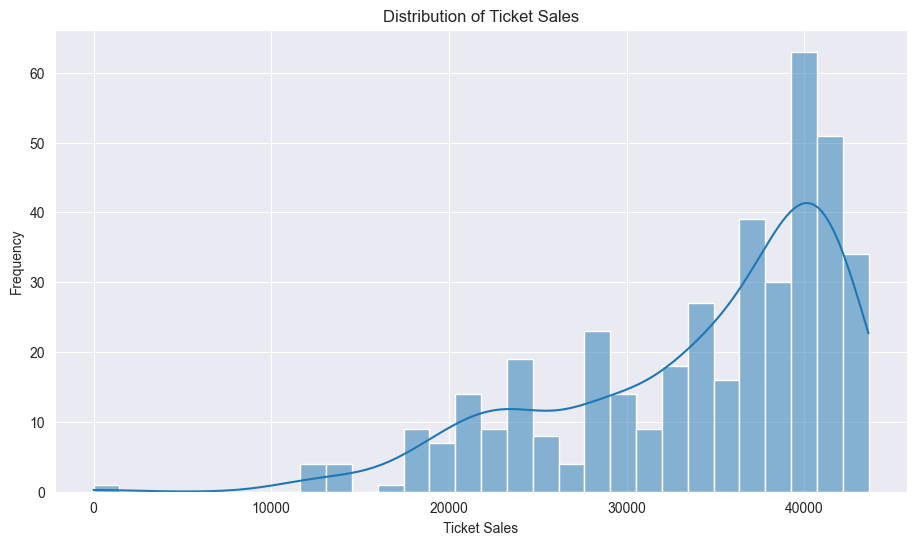

In [726]:
#Ticket Distribution
plt.figure(figsize=(11, 6))
sns.histplot(df['Tickets'], bins=30,kde=True)
plt.title('Distribution of Ticket Sales')
plt.xlabel('Ticket Sales')
plt.ylabel('Frequency')
plt.show()


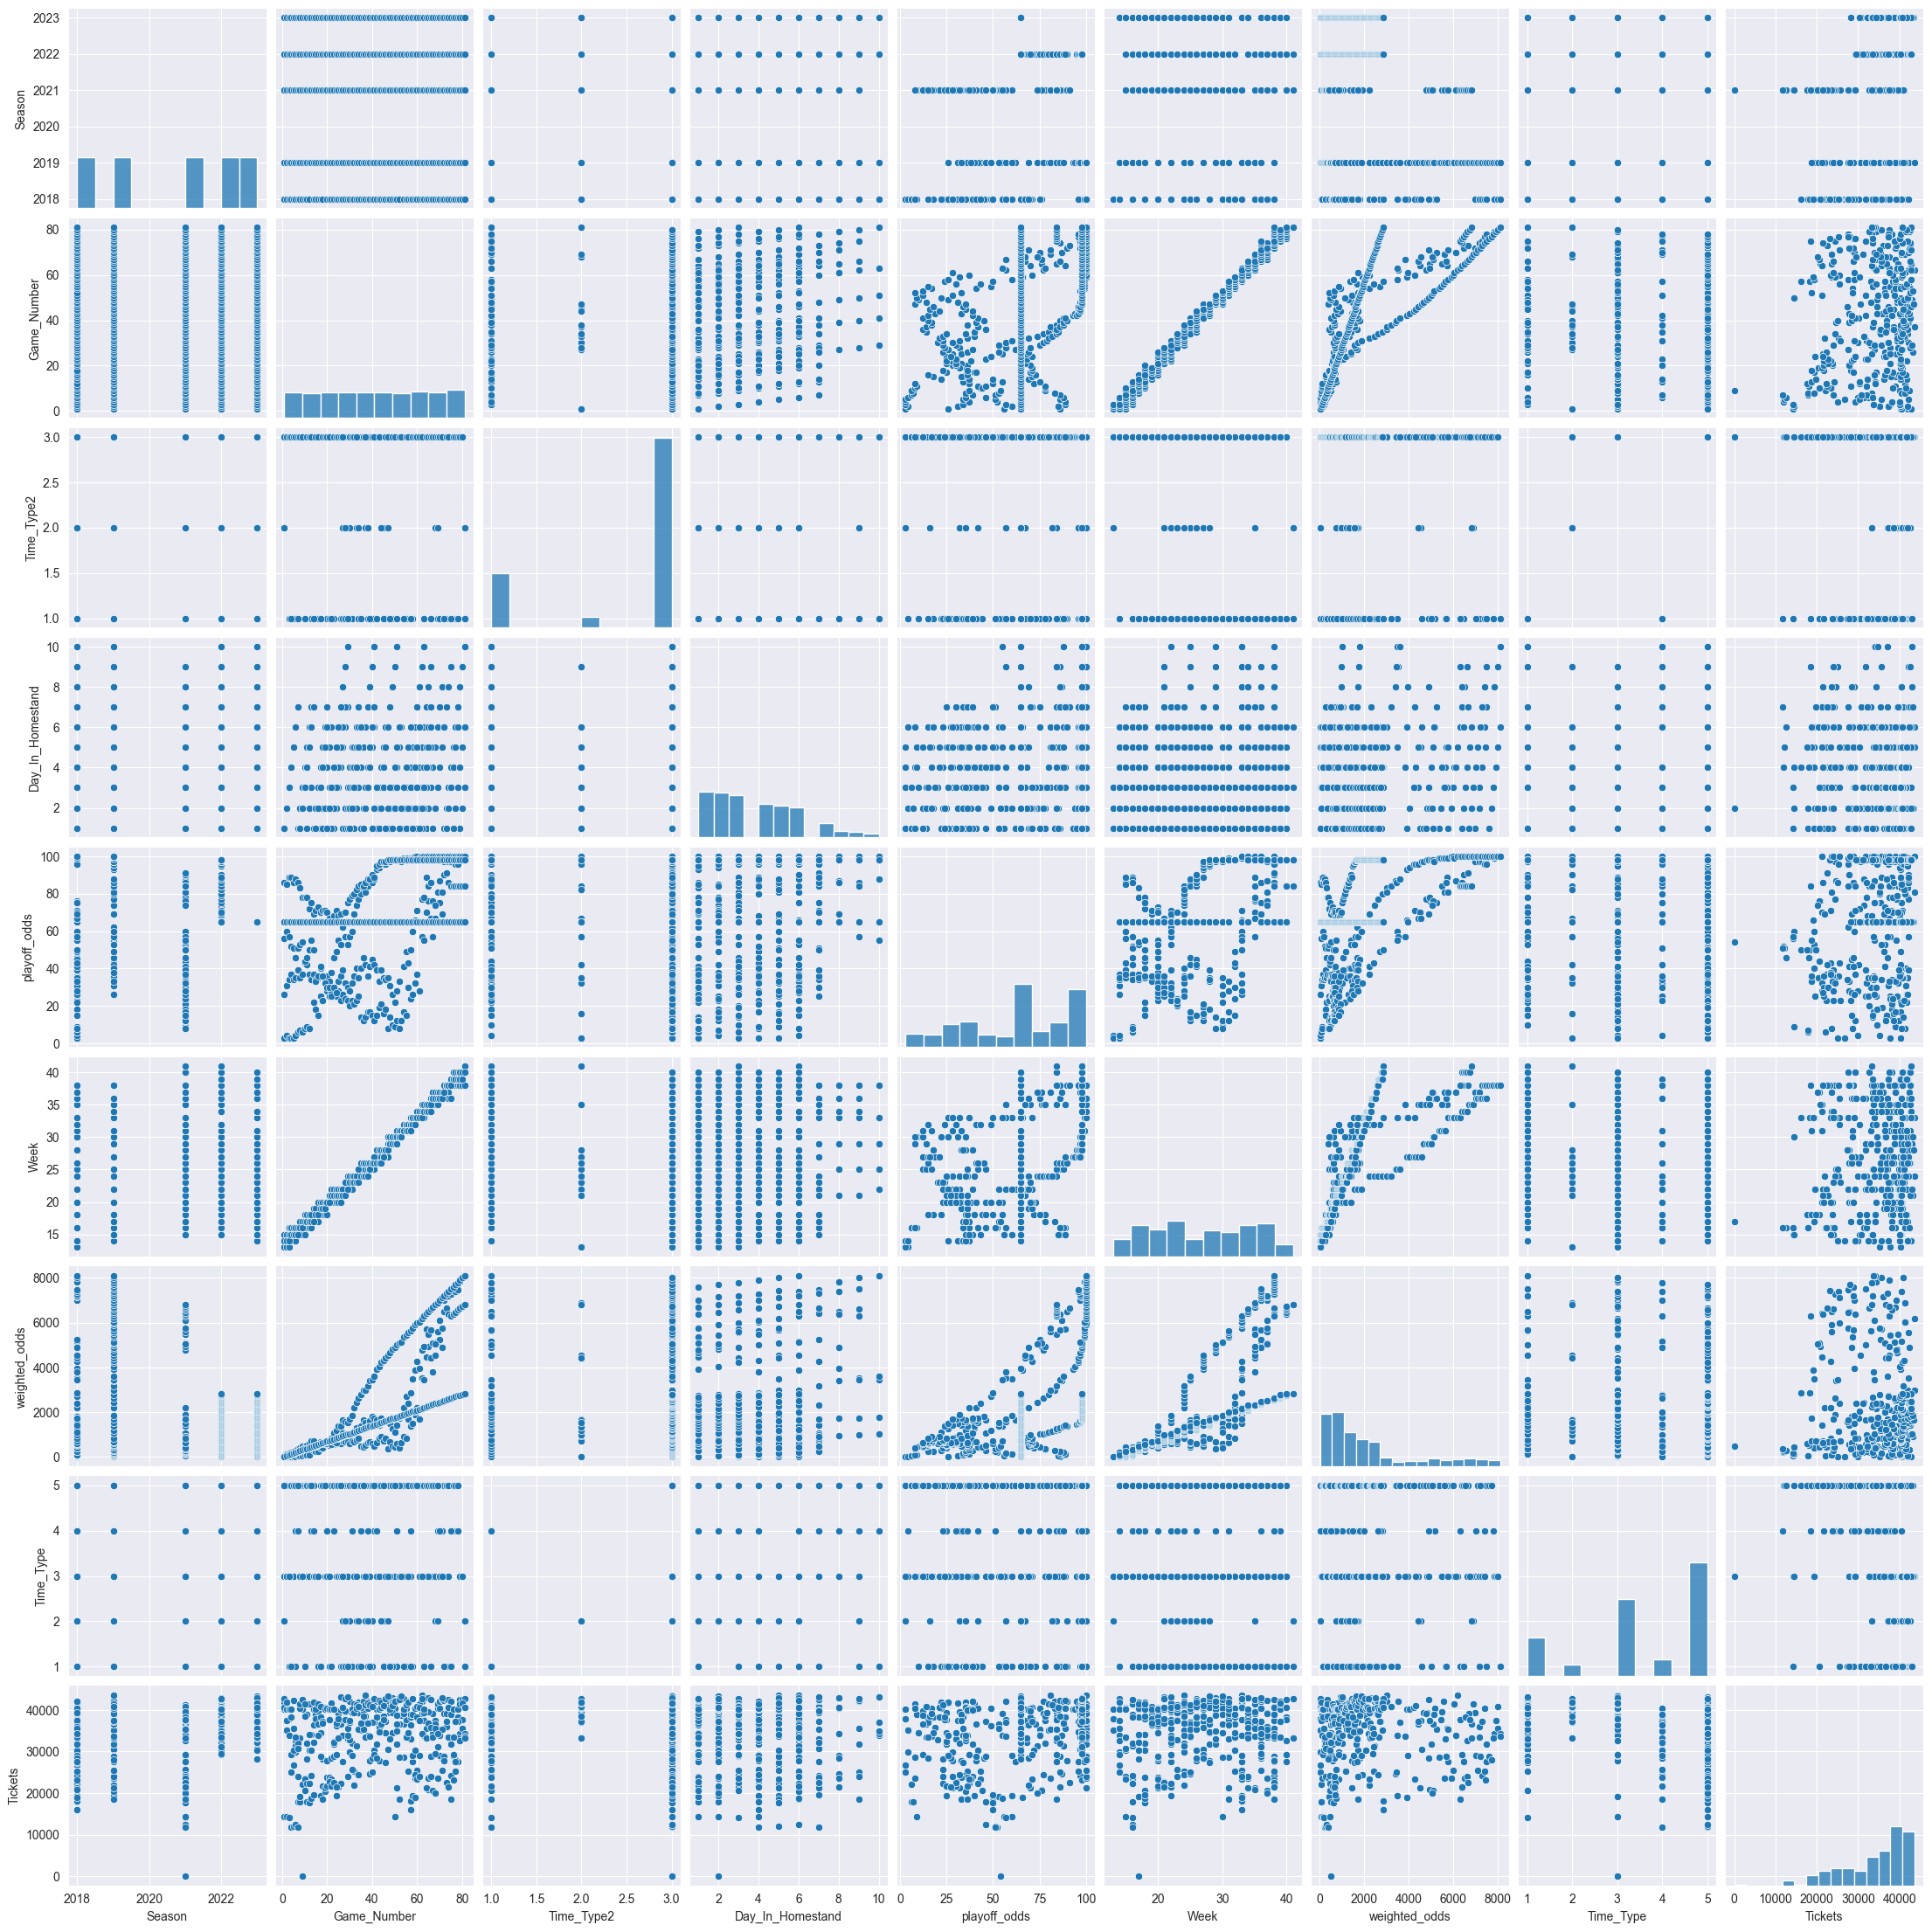

In [727]:
# Pairplot using only numeric columns
sns.pairplot(df[df.select_dtypes(include=['int64', 'float64']).columns])
plt.show()

Features Most Correlated with Tickets: 
Tickets               1.000000
Weekend               0.443579
Day                   0.373580
Season                0.355356
playoff_odds          0.235320
BobbleHead            0.166145
Game_Number           0.159889
Month                 0.157061
Week                  0.138259
afternoon_weekend     0.114648
replica               0.112992
start_of_homestand    0.078996
star_wars             0.070512
Fourth_of_july        0.052867
concert               0.050368
Opening_Day           0.034889
christian_concert     0.021767
Final_Game            0.021658
Holiday              -0.019285
end_of_homestand     -0.021556
weighted_odds        -0.029483
Time_Type2           -0.034746
afternoon_weekday    -0.107760
first_homestand      -0.124935
Day_In_Homestand     -0.125115
School               -0.272097
Time_Type            -0.353111
Name: Tickets, dtype: float64


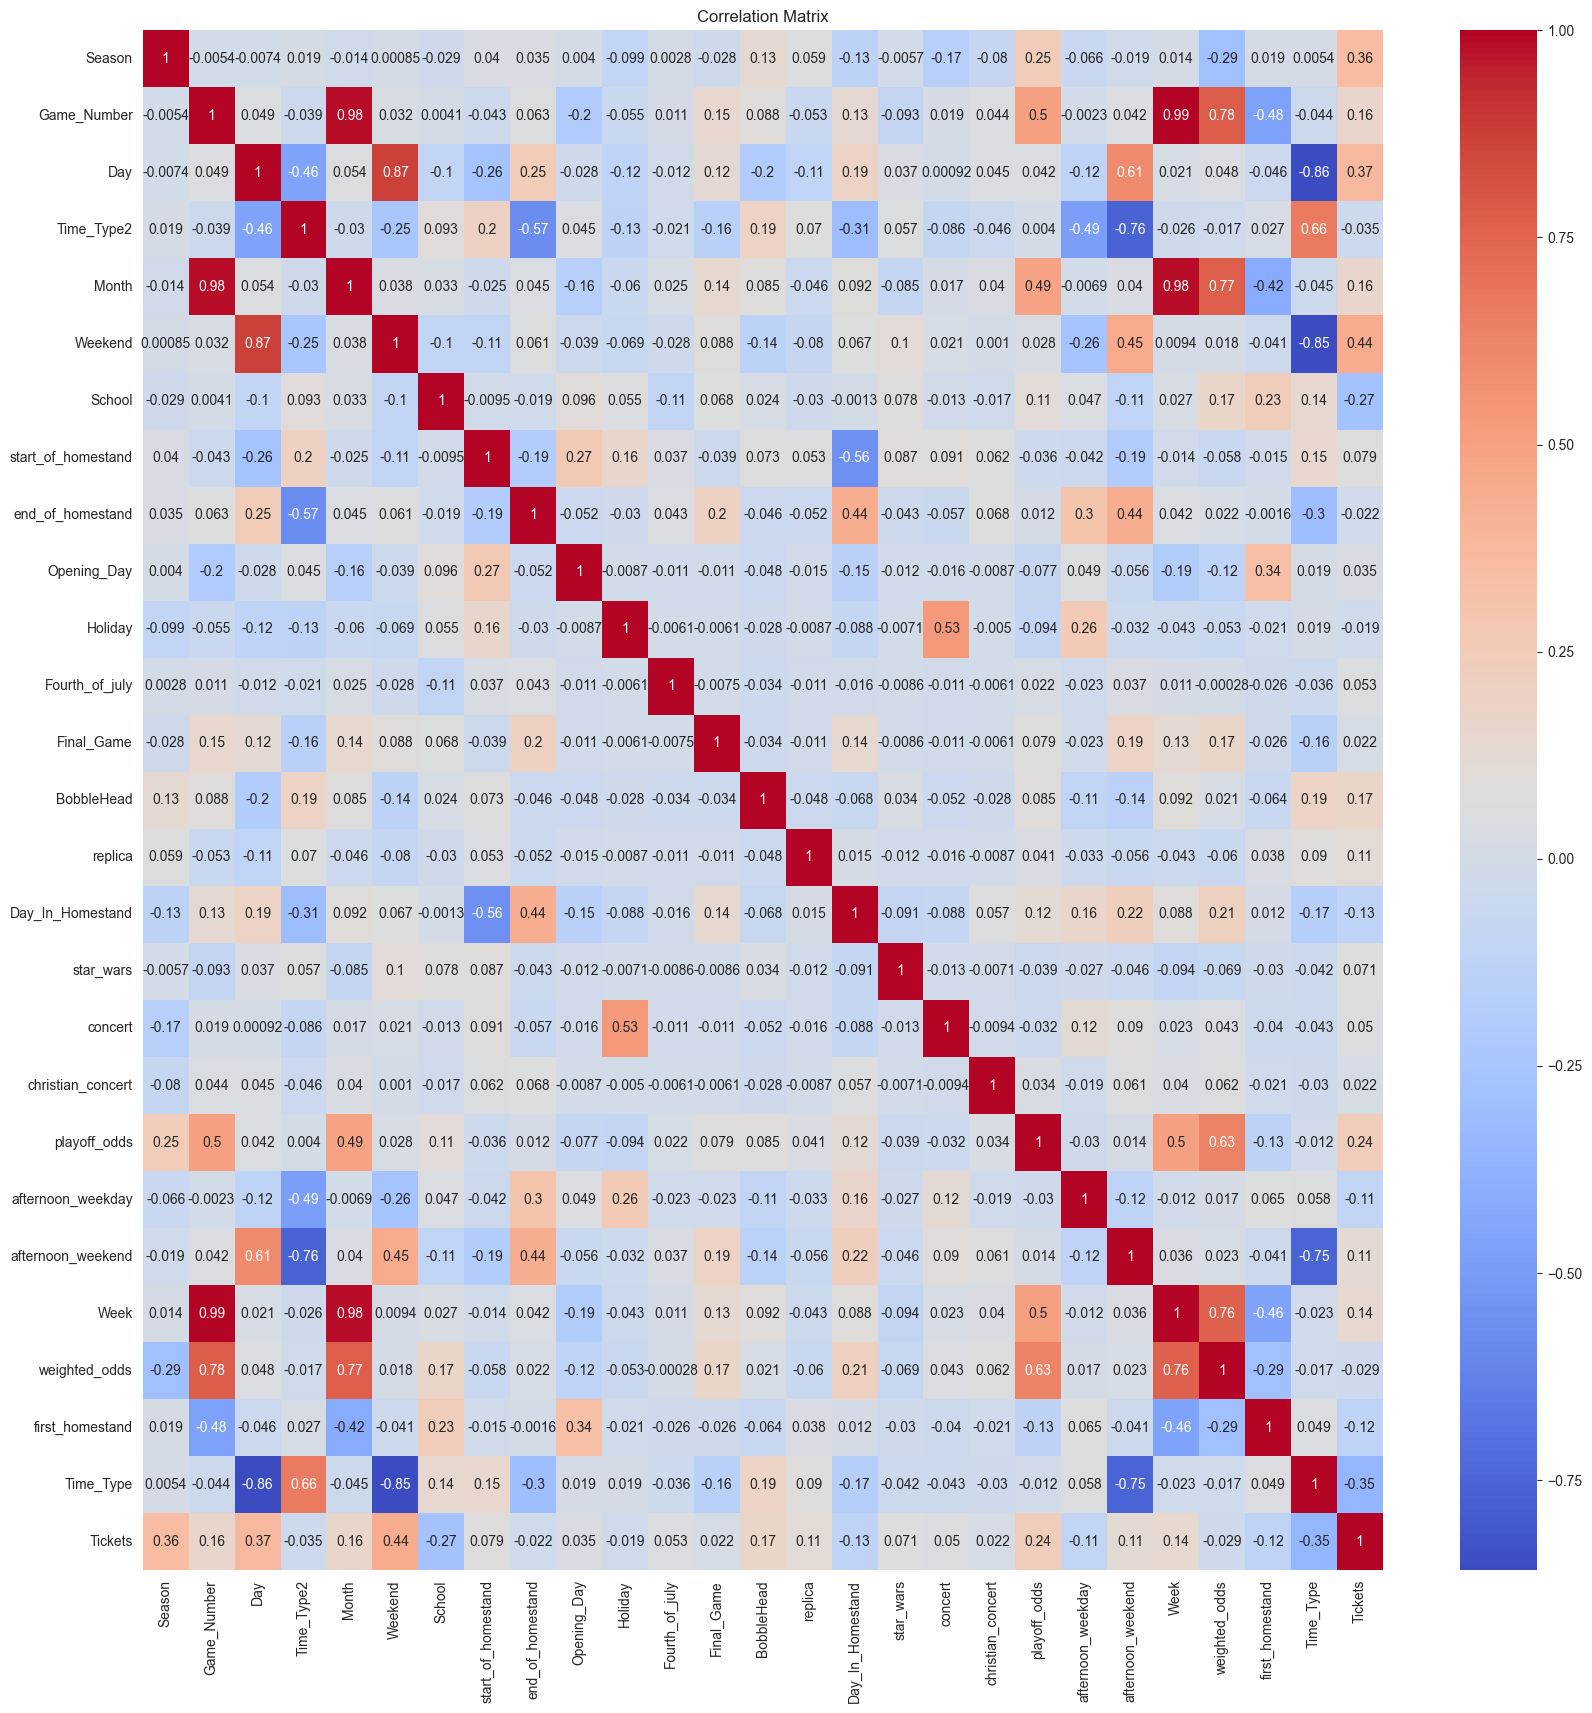

In [728]:
# Select features with high correlation to the target
correlation_matrix = df.select_dtypes(include=['number']).corr()

correlated_features = correlation_matrix['Tickets'].sort_values(ascending=False)
print("Features Most Correlated with Tickets: ")
print(correlated_features)

plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [729]:
# Finding important features within our dataset
# Separate features and target
X_mi = df.select_dtypes(include=['number']).drop(columns = 'Tickets')
y_mi = df['Tickets']
# Calculate mutual information
mutual_info = mutual_info_regression(X_mi, y_mi)

# Create a dataframe for better visualization
mi_df = pd.DataFrame({'Feature': X_mi.columns, 'Mutual Information': mutual_info})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

print("Mutual Information Scores: ")
display(mi_df)

Mutual Information Scores: 


,Feature,Mutual Information
0,Season,0.229304
19,playoff_odds,0.206378
25,Time_Type,0.189212
22,Week,0.160633
1,Game_Number,0.160605
23,weighted_odds,0.160431
2,Day,0.150440
5,Weekend,0.131580
4,Month,0.122365
6,School,0.079258


In [730]:
# Key features with zero scores should be excluded from the model:
# ["Final_Game", "Fourth_of_july", "Day_In_Homestand", "concert", "christian_concert", "Holiday", "afternoon_weekend", "start_of_homestand"]

# "event_name" is not useful as it is unique, and "date" is already represented by columns like Week and Month, making it redundant.
# "Day" is similar to "effective_day", so we should retain only one.
# "Time_Type2" is a more specific version of "Time_Type"; we should keep "Time_Type" when using the mutual information regression method.
# Further examination of "O_team" is needed.

# Potential data leakage issues:
# - "playoff_odds": If it predicts future playoff chances, it’s future-looking and unavailable at the start of the season.
# - "weighted_odds": If this reflects odds adjusted mid-season, it could cause leakage since it uses future data.
# - "BobbleHead", "replica", "star_wars", "concert", "christian_concert": These features may indicate promotions or events decided after the season starts, which could cause leakage.

df['Time_of_year'] = df['Time_of_year'].map({
    'April': 0,
    'August College': 1,
    'August No College': 2,
    'July': 3,
    'July 4th': 4,
    'July 4th Week': 5,
    'June 1st Half': 6,
    'June 2nd Half': 7,
    'May No School': 8,
    'May School': 9,
    'Opening Day': 10,
    'Opening Homestand': 11,
    'Opening Saturday': 12,
    'September 1st Half': 13,
    'September 2nd Half': 14
})

df['Time_of_year'] = df['Time_of_year'].astype(int)

X = df.drop(columns=["event_name", "O_Team","playoff_odds","weighted_odds","replica","star_wars","Time_Type2","effective_day","Final_Game", "Fourth_of_july", "concert", "christian_concert", "Holiday", "afternoon_weekend", "first_homestand", "start_of_homestand", "Tickets"])
y = df['Tickets']

### 1. Time-Based Train-Test Split by Year ###
X_train = X[X.index.year < 2023]  # First 4 years as training
X_test = X[X.index.year == 2023]  # Last year as testing

# Split target variable
y_train = y[y.index.year < 2023]
y_test = y[y.index.year == 2023]

In [731]:
print(X_train.columns)

Index(['Season', 'Game_Number', 'Day', 'Month', 'Weekend', 'School',
       'end_of_homestand', 'Opening_Day', 'BobbleHead', 'Day_In_Homestand',
       'afternoon_weekday', 'Week', 'Time_Type', 'Time_of_year'],
      dtype='object')


# XGBoost

In [732]:
d_train = xgb.DMatrix(X_train,y_train, enable_categorical=True)
d_test = xgb.DMatrix(X_test,y_test, enable_categorical=True)

params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',  # Root Mean Squared Error for regression
    'max_depth': 3,
    'eta': 0.1,
}

# Training the XGBoost model
xgb_model = xgb.train(params, d_train, num_boost_round=100)
y_pred = xgb_model.predict(d_test)
print("RMSE ",root_mean_squared_error(y_test,y_pred))
print("Mean Absolute Error ",mean_absolute_error(y_test,y_pred))

RMSE  3091.482586703237
Mean Absolute Error  2342.779224537037


In [733]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
print("RMSE ",root_mean_squared_error(y_test,y_pred))
print("Mean Absolute Error ",mean_absolute_error(y_test,y_pred))

RMSE  3155.3813890769743
Mean Absolute Error  2421.236049382716


In [734]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train,y_train)
y_pred = dt_model.predict(X_test)
print("RMSE ",root_mean_squared_error(y_test,y_pred))
print("Mean Absolute Error ",mean_absolute_error(y_test,y_pred))

RMSE  4355.448554524679
Mean Absolute Error  3245.2716049382716


In [735]:
# I have chosen XGBoost since it has the lowest RMSE
prediction_data = pd.read_csv('data/prediction_data/2024_Schedule_info.csv')
ticketing_data_2024 = pd.read_csv('data/prediction_data/2024_Ticketing_Data.csv')

prediction_data = prediction_data[['Season', 'Game_Number', 'Day', 'Month', 'Weekend', 'School',
       'end_of_homestand', 'Opening_Day', 'BobbleHead', 'Day_In_Homestand',
       'afternoon_weekday', 'Week', 'Time_Type', 'Time_of_year']]

print(prediction_data.columns)
prediction_data.loc[:,'Day'] = prediction_data['Day'].map({'MON': 0,'TUE': 1,'WED': 2,'THU': 3,'FRI': 4,'SAT': 5, 'SUN': 6})
prediction_data.loc[:,'Month'] = prediction_data['Month'].map({ 'Jan': 0,'Feb': 1,'Mar': 2, 'Apr': 3,'May': 4,'Jun': 5,'Jul': 6, 'Aug': 7,'Sep': 8,'Oct': 9,'Nov': 10,'Dec': 11})

prediction_data.loc[:,'Time_of_year'] = prediction_data['Time_of_year'].map({
    'April': 0,
    'August College': 1,
    'August No College': 2,
    'July': 3,
    'July 4th': 4,
    'July 4th Week': 5,
    'June 1st Half': 6,
    'June 2nd Half': 7,
    'May No School': 8,
    'May School': 9,
    'Opening Day': 10,
    'Opening Homestand': 11,
    'Opening Saturday': 12,
    'September 1st Half': 13,
    'September 2nd Half': 14
})

prediction_data['Time_of_year'] = prediction_data['Time_of_year'].astype(int)
prediction_data['Day'] = prediction_data['Day'].astype(int)
prediction_data['Month'] = prediction_data['Month'].astype(int)

predictions = xgb_model.predict(xgb.DMatrix(prediction_data))

Index(['Season', 'Game_Number', 'Day', 'Month', 'Weekend', 'School',
       'end_of_homestand', 'Opening_Day', 'BobbleHead', 'Day_In_Homestand',
       'afternoon_weekday', 'Week', 'Time_Type', 'Time_of_year'],
      dtype='object')


In [736]:
# Create a DataFrame with predictions
prediction_results = pd.DataFrame({
    'event_name': ticketing_data_2024['event_name'],
    'Date ': ticketing_data_2024['Date'],
    'Tickets': predictions
})

prediction_results['Tickets'] = prediction_results['Tickets'].round().astype(int)
# Save predictions to CSV
prediction_results.to_csv('prediction_results.csv', index=False)